In [1]:
"""
Analyze GRASP for each detector design
author: Jiancheng Zeng
Date: May 1, 2023
"""

'\nAnalyze GRASP for each detector design\nauthor: Jiancheng Zeng\nDate: May 1, 2023\n'

In [184]:
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
  
def read_data_from_toymodel(file_path):
    print("Reading data...\n")
    try:
        df = pd.read_csv(file_path, delimiter='\t')  # Assumes tab-separated values in the text file

        # Name each data group with event ID
        grouped = df.groupby(df.iloc[:, 0])

        # Create an empty dictionary to store the 3D data structure
        data_3d = {}

        # Iterate over each group and populate the dictionary
        for group_name, group_data in grouped:
            data_3d[group_name] = group_data.values
        
        print("Toy Model data imported\nFound " + str(len(list(data.keys()))) + " Events!")
        return data_3d
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except pd.errors.ParserError:
        print(f"Error: Unable to parse data from '{file_path}'. Please ensure the file has the correct format.")
        return None

""" 
This function doing GRASP analysis
"""
def Analyze_GRASP(data_3d, particle_ID, stop_event=False):
    Event_list = list(data_3d.keys())
    Init_Energy = []
    N_stop_event = 0
    for i in range(len(Event_list)):
        Energy_out = 0
        Energy_in = 0
        for j in range(len(data_3d[Event_list[i]])):
            if(str(data_3d[Event_list[i]][j, 5]) == '-10000' or str(data_3d[Event_list[i]][j, 5]) == '-10001' or str(data_3d[Event_list[i]][j, 5]) == '-10002' or str(data_3d[Event_list[i]][j, 5]) == '-10003' or str(data_3d[Event_list[i]][j, 5]) == '-10004' or str(data_3d[Event_list[i]][j, 5]) == '-10005' and str(data_3d[Event_list[i]][3]) == str(particle_ID)):
                Energy_out = Energy_out + float(data_3d[Event_list[i]][j, 9])
                #print(Energy_out)
                #if str(data_3d[Event_list[i]][j+1, 5]) != str(data_3d[Event_list[i]][j, 5]):
                    #break
            if(str(data_3d[Event_list[i]][j, 5]) == '-11000' or str(data_3d[Event_list[i]][j, 5]) == '-11001' or str(data_3d[Event_list[i]][j, 5]) == '-11002' or str(data_3d[Event_list[i]][j, 5]) == '-11003' or str(data_3d[Event_list[i]][j, 5]) == '-11004' or str(data_3d[Event_list[i]][j, 5]) == '-11005' and str(data_3d[Event_list[i]][3]) == str(particle_ID)):
                Energy_in = Energy_in + float(data_3d[Event_list[i]][j, 9])
        if(stop_event == True):
            condition = np.min(data_3d[Event_list[i]][:, 8]) == 0 and np.min(data_3d[Event_list[i]][:, 9]) == 0 and stop_event
        else:
            condition = True

        if(Energy_in != 0 and Energy_out != 0 and condition):
            N_stop_event = N_stop_event + 1
            Init_Energy.append(data_3d[Event_list[i]][0, 8])
        print("Now processing (" + str(i) + "/" + str(len(Event_list))+")",  end='\r')
    print("\n We got " + str(N_stop_event) + " events selected")
    return np.array(Init_Energy)

def Analyze_TOF(data_3d, particle_ID, stop_event=False):
    Event_list = list(data_3d.keys())
    TOF_out_E = []
    TOF_in_E = []
    for i in range(len(Event_list)):
        Energy_out = 0
        Energy_in = 0
        for j in range(len(data_3d[Event_list[i]])):
            if(str(data_3d[Event_list[i]][j, 5]) == '-10000' or str(data_3d[Event_list[i]][j, 5]) == '-10001' or str(data_3d[Event_list[i]][j, 5]) == '-10002' or str(data_3d[Event_list[i]][j, 5]) == '-10003' or str(data_3d[Event_list[i]][j, 5]) == '-10004' or str(data_3d[Event_list[i]][j, 5]) == '-10005' and str(data_3d[Event_list[i]][3]) == str(particle_ID)):
                Energy_out = Energy_out + float(data_3d[Event_list[i]][j, 9])
                #print(Energy_out)
                #if str(data_3d[Event_list[i]][j+1, 5]) != str(data_3d[Event_list[i]][j, 5]):
                    #break
            if(str(data_3d[Event_list[i]][j, 5]) == '-11000' or str(data_3d[Event_list[i]][j, 5]) == '-11001' or str(data_3d[Event_list[i]][j, 5]) == '-11002' or str(data_3d[Event_list[i]][j, 5]) == '-11003' or str(data_3d[Event_list[i]][j, 5]) == '-11004' or str(data_3d[Event_list[i]][j, 5]) == '-11005' and str(data_3d[Event_list[i]][3]) == str(particle_ID)):
                Energy_in = Energy_in + float(data_3d[Event_list[i]][j, 9])
        if(stop_event==True):
            condition = np.min(data_3d[Event_list[i]][:, 8]) == 0 and np.min(data_3d[Event_list[i]][:, 9]) == 0 and stop_event
        else:
            condition = True

        if(Energy_in != 0 and Energy_out != 0 and condition):
            TOF_out_E.append(Energy_out)
            TOF_in_E.append(Energy_in)
        print("Now processing (" + str(i) + "/" + str(len(Event_list))+")",  end='\r')
    Result_Vector = np.array([TOF_out_E, TOF_in_E])
    print("\n")
    return Result_Vector

def GRASP_hist(GRASP_vector, particle_ID, label):
    GRASP_bin = []
    Xaxis = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500]
    Xaxis = np.array(Xaxis) / number_of_nucleons(particle_ID)[1]
    centersXaxis = Xaxis[:-1] + np.diff(Xaxis) / 2

    for i in range(30):
        GRASP_bin.append(400 * math.pi * len(GRASP_vector[np.logical_and(GRASP_vector>i*50, GRASP_vector<(i+1)*50)])/(Event_list[len(Event_list)-1]/30))
        #GRASP_anti_He3_Inflight[i] = 400 * math.pi * len(anti_He3_Inflight[np.logical_and(anti_He3_Inflight>i*50, anti_He3_Inflight<(i+1)*50)])/(First_Evnets/30)

    plt.stairs(GRASP_bin , Xaxis, baseline=None, label=label, alpha=0.99)

def number_of_nucleons(particle_ID):
    data = [[2212, 1000010020, 1000020030, -2212, -1000010020, -1000020030],
            [1, 2, 3, 1, 2, 3]]
    df = pd.DataFrame(data, columns=['proton', 'deuteron', 'helium3', 'antiproton', 'antideuteron', 'antihelium3'])
    matching_columns = df.columns[df.eq(particle_ID).any()]
    particle_info = df[matching_columns[0]]
    return particle_info


Reading data...

Toy Model data imported
Found 21903 Events!
Now processing (21902/21903)
 We got 4042 events selected
Reading data...

Toy Model data imported
Found 21903 Events!
Now processing (20862/20863)
 We got 3742 events selected


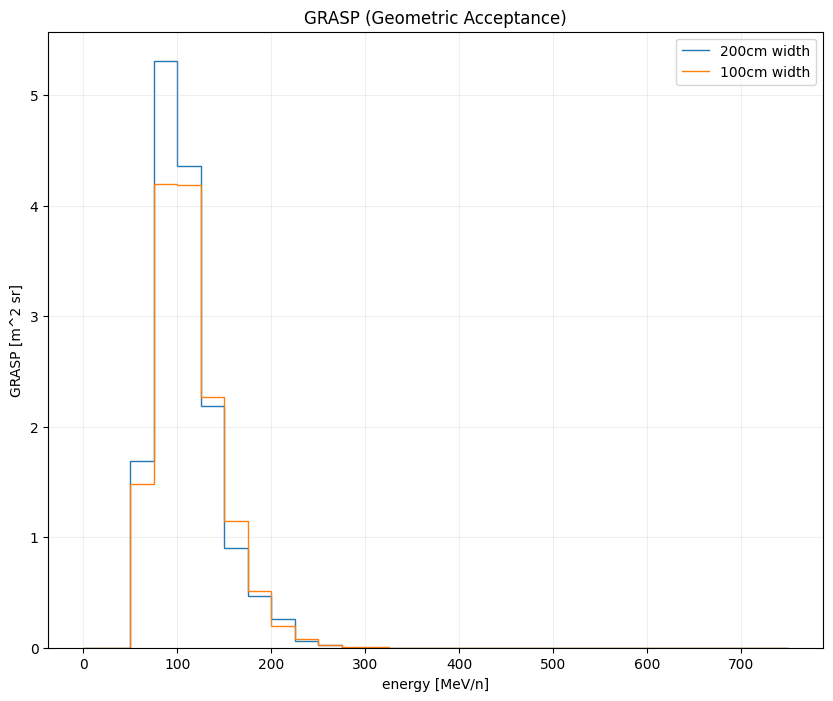

In [188]:
# Create a new figure
plt.figure(figsize=(10, 8))

file_path_200 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_1e7_200cm.dat'
label1 = '200cm width'
plot_200 = GRASP_hist(Analyze_GRASP(read_data_from_toymodel(file_path_200) , -1000010020, stop_event=True), -1000010020, label1)

file_path_73 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_1e7_73cm.dat'
label2 = '73cm width'
plot_100 = GRASP_hist(Analyze_GRASP(read_data_from_toymodel(file_path_73) , -1000010020, stop_event=True), -1000010020, label2)

plt.xlabel("energy [MeV/n]")
plt.ylabel("GRASP [m^2 sr]")
plt.legend()
plt.grid(alpha=0.2)
plt.title('GRASP (Geometric Acceptance)')

# Show the figure
plt.show()

    